In [1]:
import numpy as np
import pygmt as pygmt
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from faultSlip.inversion import Inversion
from faultSlip.utils import *

# Normal faulting example
## strike 180
## dip 45
## dip element = 1

In [2]:
strike, dip = 180, 45

In [3]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * -0.1

/var/folders/c_/7wmr5s157236k916wk7m39800000gn/T/ipykernel_39746/3160620564.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))


In [4]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [5]:
x = 50.01
y = 50.01
z = 0.2
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = 10.0
W = 10.0
slip_strike = 0.0
slip_dip = -1.0
s_open = 0.0

In [6]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[50.01      , 55.01      ,  0.2       ],
       [50.01      , 45.01      ,  0.2       ],
       [42.93893219, 45.01      ,  7.27106781],
       [42.93893219, 55.01      ,  7.27106781]])

In [20]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [21]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

# reciver dislocation
## calculating the stress on the same orentaion (dip:45 strike:180)
## rake:90 represent normal faulting

In [22]:
r_strike = np.radians(strike)
r_dip = np.radians(dip)
r_rake = np.radians(90)

In [23]:
yang_mod = 8*1e6
poisson = 0.25
lame_lambda = (yang_mod * poisson) / ((1 + poisson) * ( 1 - 2 * poisson))
shear_mod = yang_mod / (2 * (1 + poisson))
lame_lambda, shear_mod

(3200000.0, 3200000.0)

In [25]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(inv.solution)
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


In [26]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
inv_tn = get_array(tn, X[0, :], Y[:, 0])
inv_ts = get_array(ts, X[0, :], Y[:, 0])
inv_coulomb = get_array(coulomb, X[0, :], Y[:, 0])

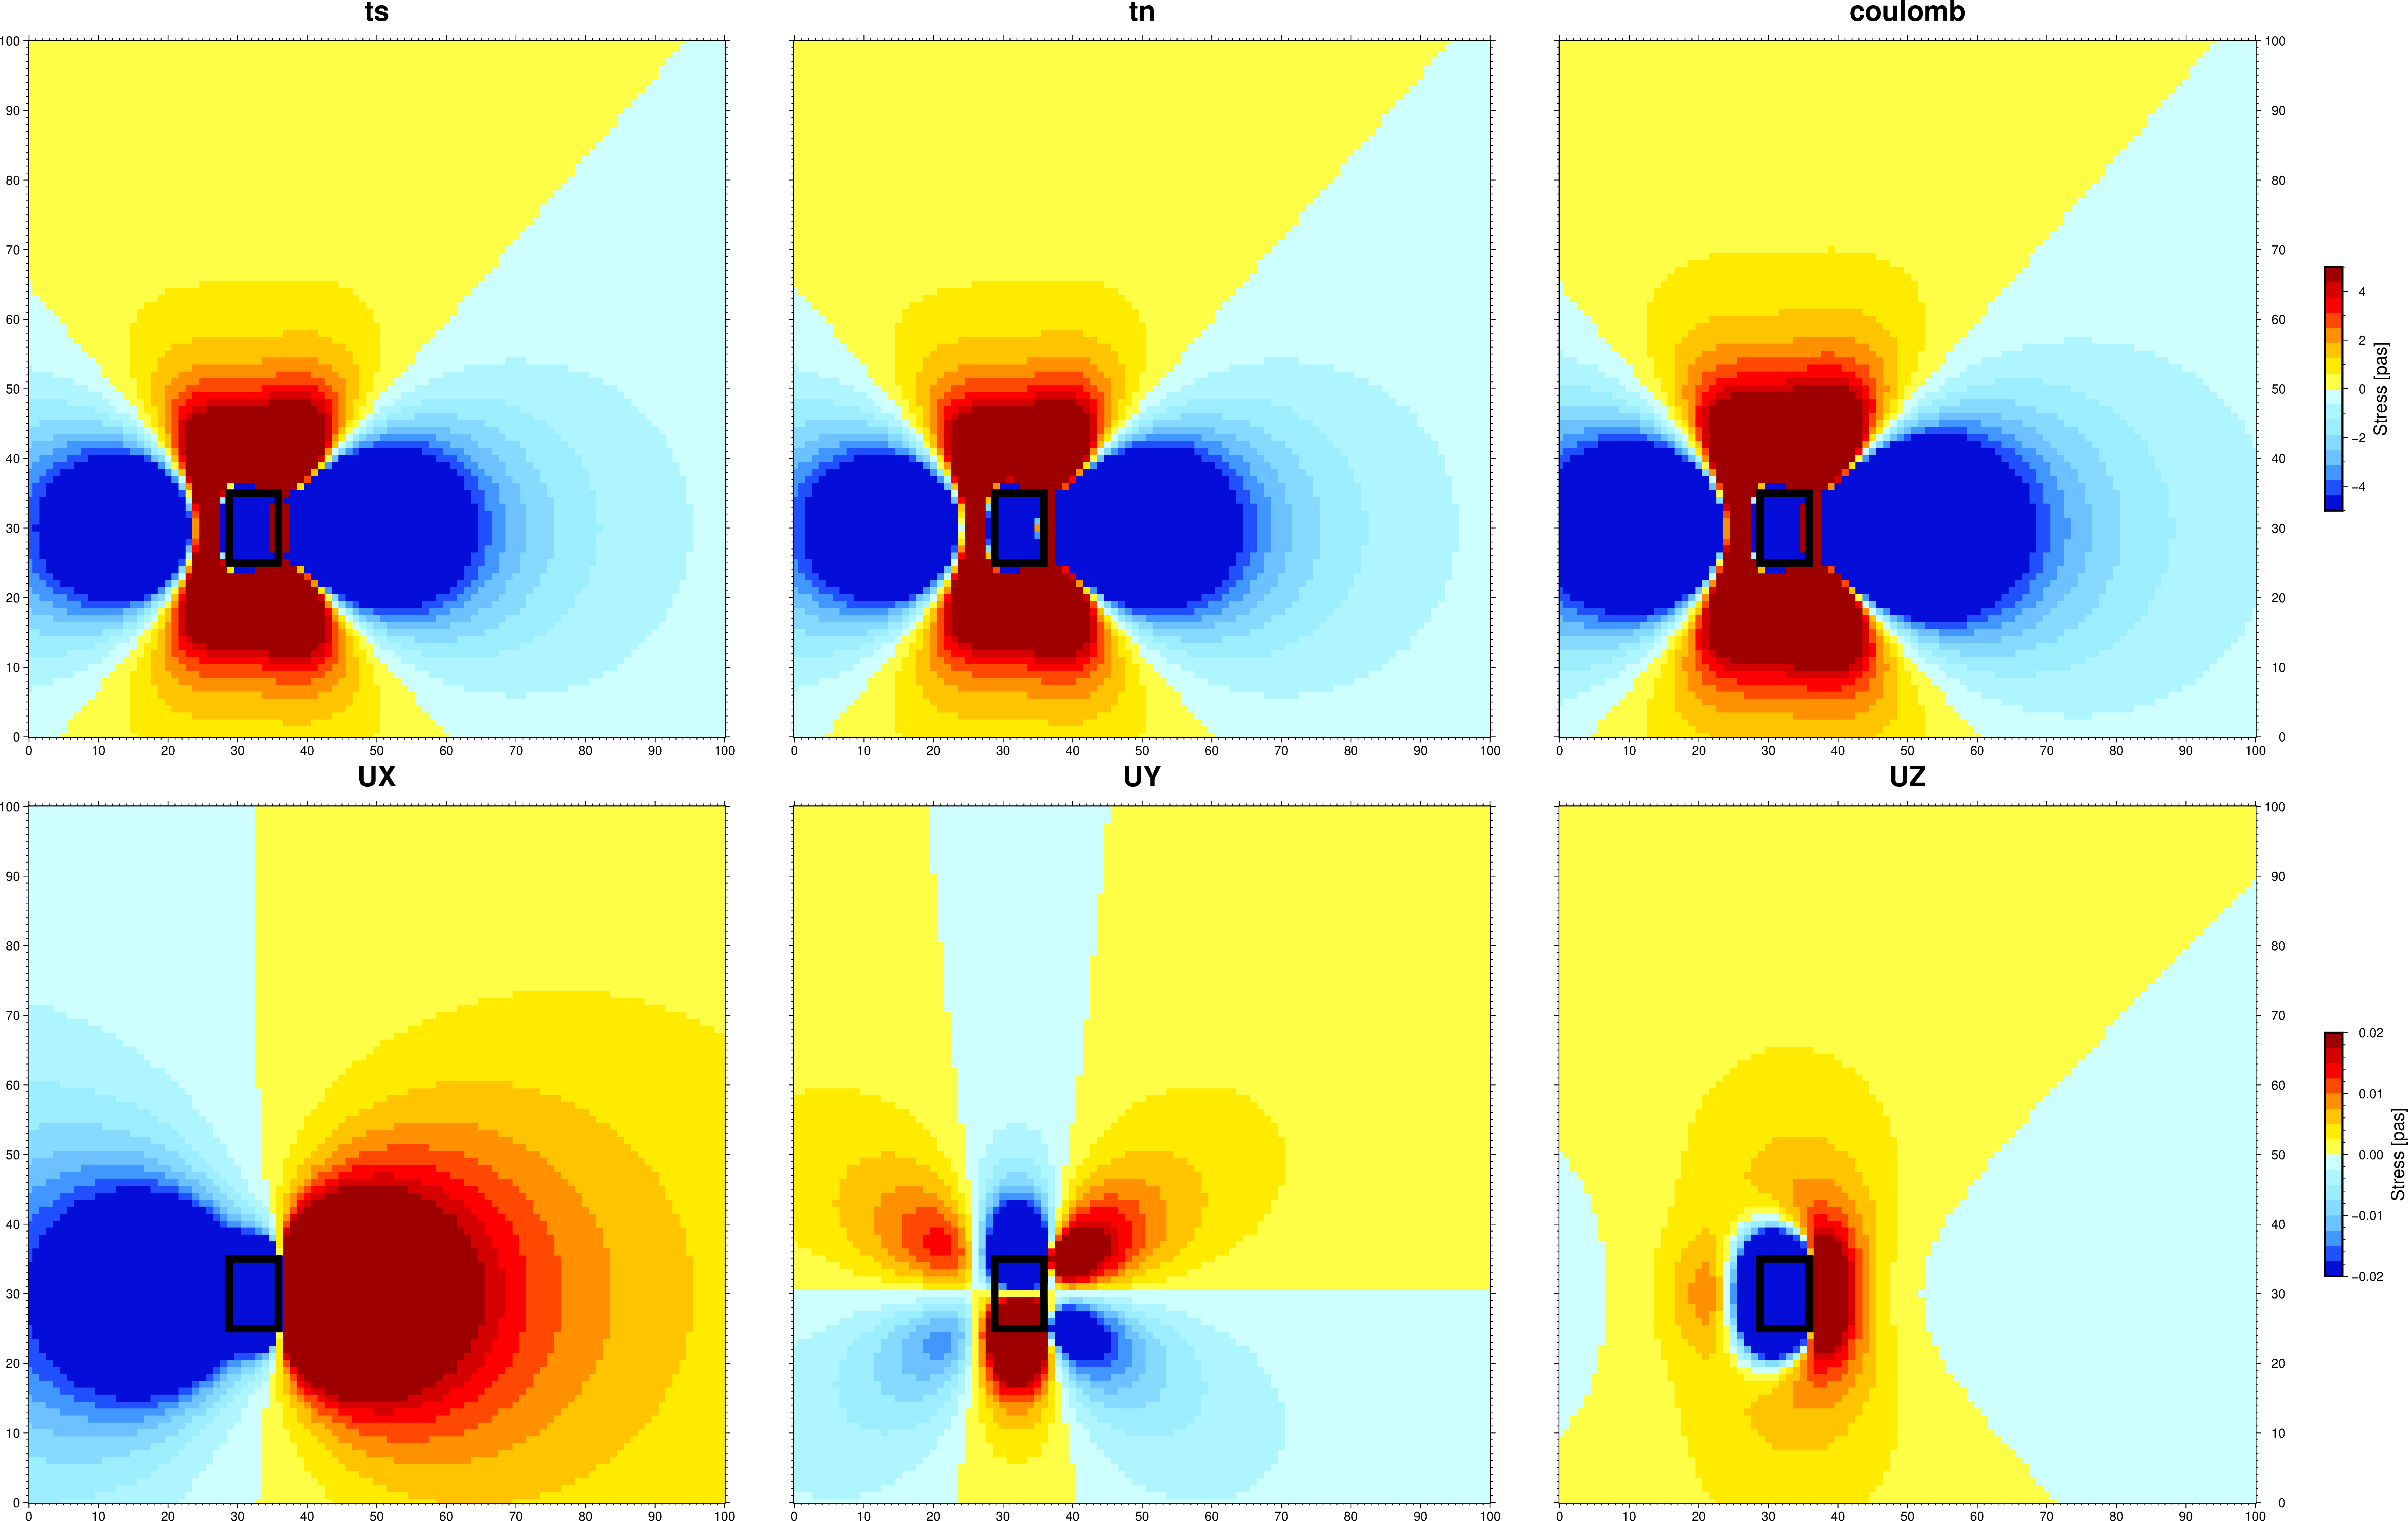

In [27]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44c', yshift='22c')



fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [15]:
X, Z = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, -20, 100))
Y = np.ones_like(X) * 50.0

In [52]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
tn_da = get_array(tn, X[0, :], Z[:, 0])
ts_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [53]:
region=[0,100,-20,0]

In [54]:
disp = inv.calc_disp(X, Z)
ux_da = get_array(disp[0], X[0, :], Z[:, 0])
uy_da = get_array(disp[0], X[0, :], Z[:, 0])
uz_da = get_array(disp[0], X[0, :], Z[:, 0])

In [55]:
ux_da.max().data

array(0.00188118)

In [56]:
max(float(ux_da.max().data), float(uy_da.max().data), float(uz_da.max().data))

0.0018811821594036382

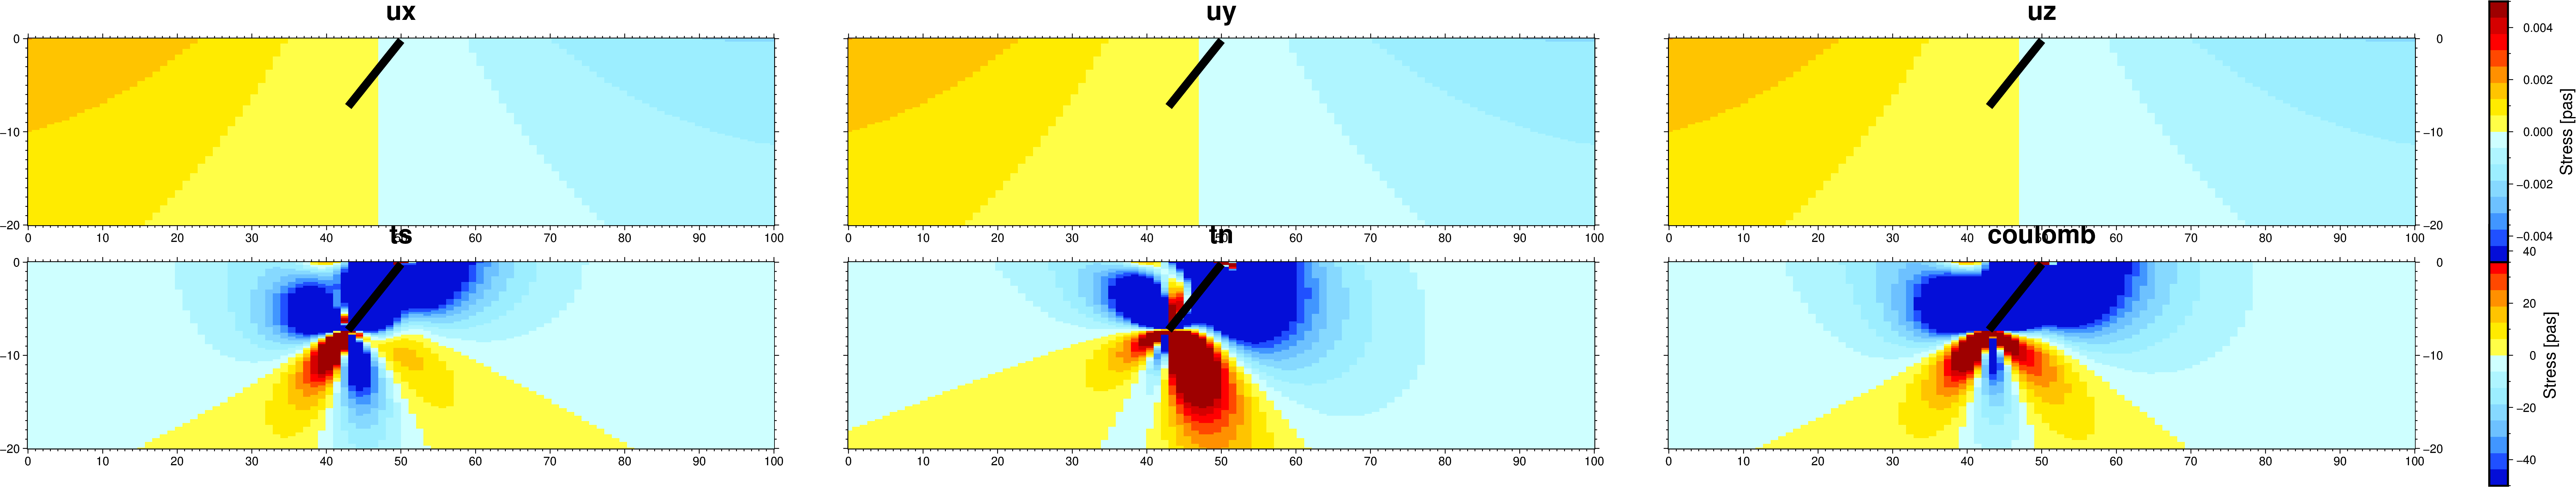

In [57]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 50#float(shear_da.max().data) * 0.05
mmin = -50#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ts_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=tn_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44', yshift='6')
fig.basemap(
    frame=['WSne+t"ux"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 0.005#float(shear_da.max().data) * 0.05
mmin = -0.005#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ux_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"uy"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=uy_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"uz"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=uz_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')
fig.show(width=1200)

# reverse faulting example
## strike 180
## dip 45
## dip element = -1

In [24]:
strike, dip = 180, 45

In [46]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * 0.1

In [26]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [27]:
x = 50.01
y = 50.01
z = 0.2
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = 10.0
W = 10.0
slip_strike = 0.0
slip_dip = -1.0
s_open = 0.0

In [28]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[50.01      , 55.01      ,  0.2       ],
       [50.01      , 45.01      ,  0.2       ],
       [42.93893219, 45.01      ,  7.27106781],
       [42.93893219, 55.01      ,  7.27106781]])

In [29]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [30]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

# reciver dislocation
## calculating the stress on the same orentaion (dip:45 strike:180)
## rake:90 represent reverse faulting

In [40]:
r_strike = np.radians(strike)
r_dip = np.radians(dip)
r_rake = np.radians(90)

In [41]:
yang_mod = 8*1e6
poisson = 0.25
lame_lambda = (yang_mod * poisson) / ((1 + poisson) * ( 1 - 2 * poisson))
shear_mod = yang_mod / (2 * (1 + poisson))
lame_lambda, shear_mod

(3200000.0, 3200000.0)

In [47]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(inv.solution)
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


In [48]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
inv_tn = get_array(tn, X[0, :], Y[:, 0])
inv_ts = get_array(ts, X[0, :], Y[:, 0])
inv_coulomb = get_array(coulomb, X[0, :], Y[:, 0])

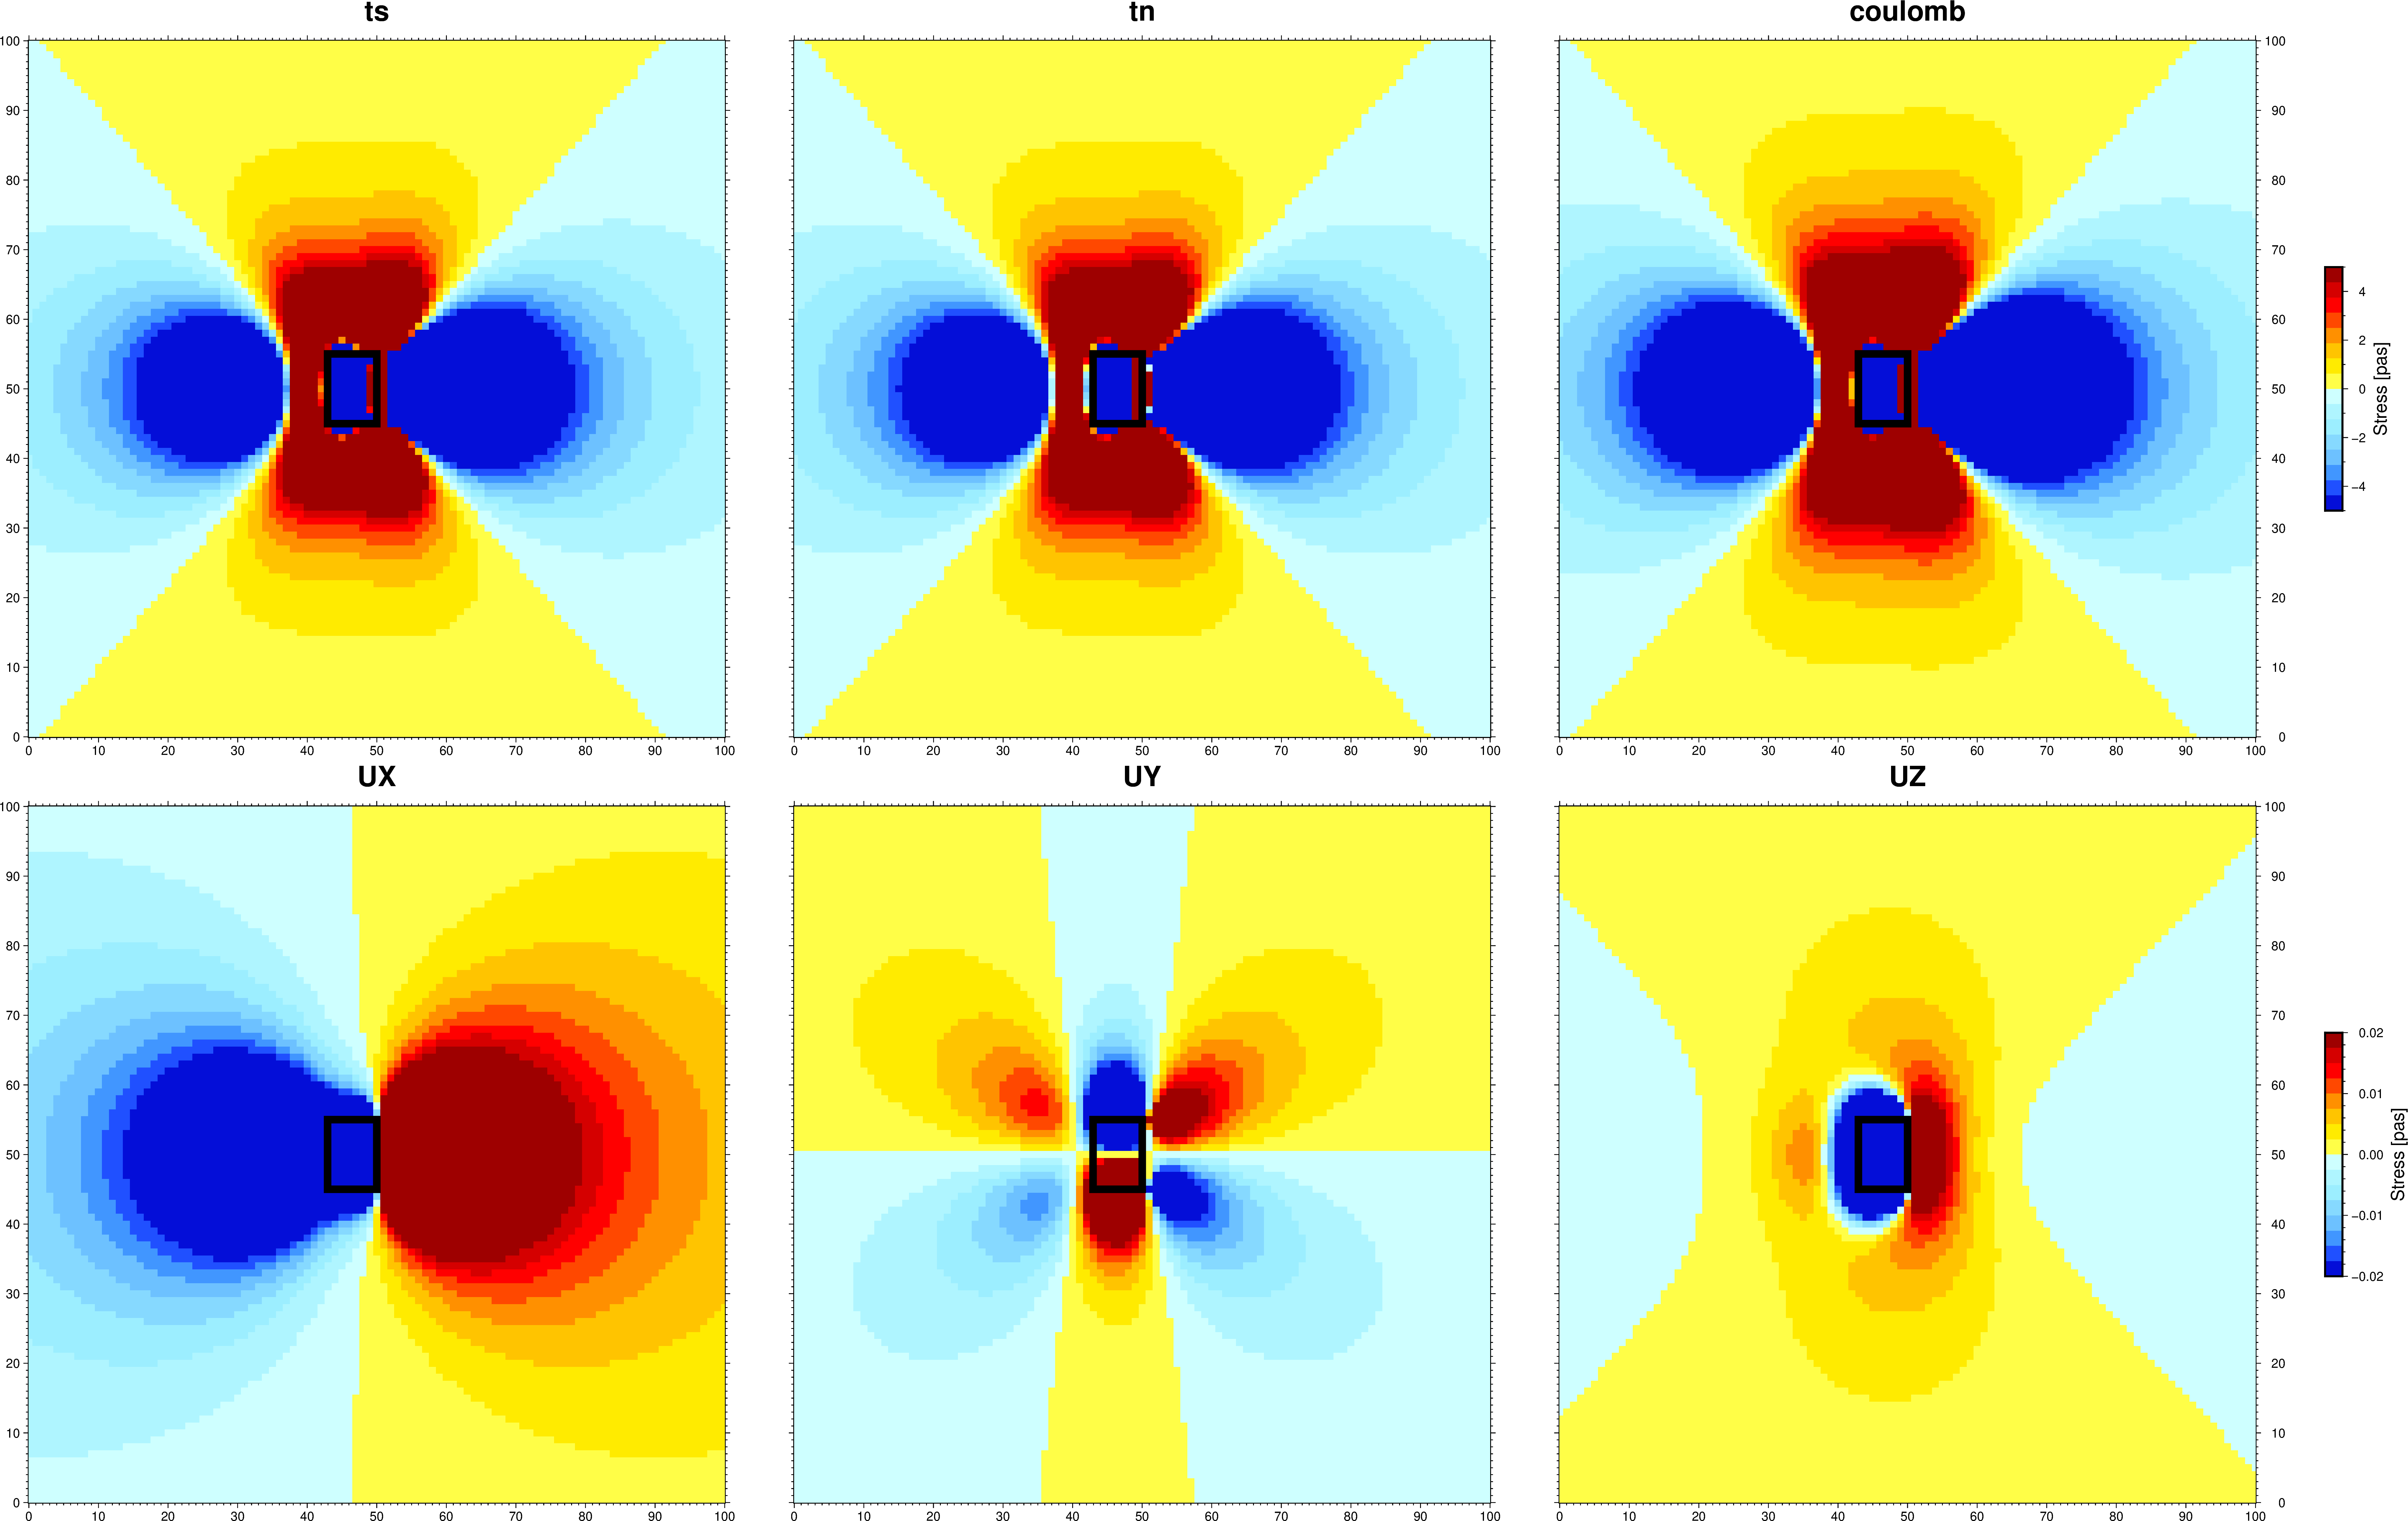

In [49]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44c', yshift='22c')



fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [50]:
X, Z = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, -20, 100))
Y = np.ones_like(X) * 50.0

In [51]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
tn_da = get_array(tn, X[0, :], Z[:, 0])
ts_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [52]:
region=[0,100,-20,0]

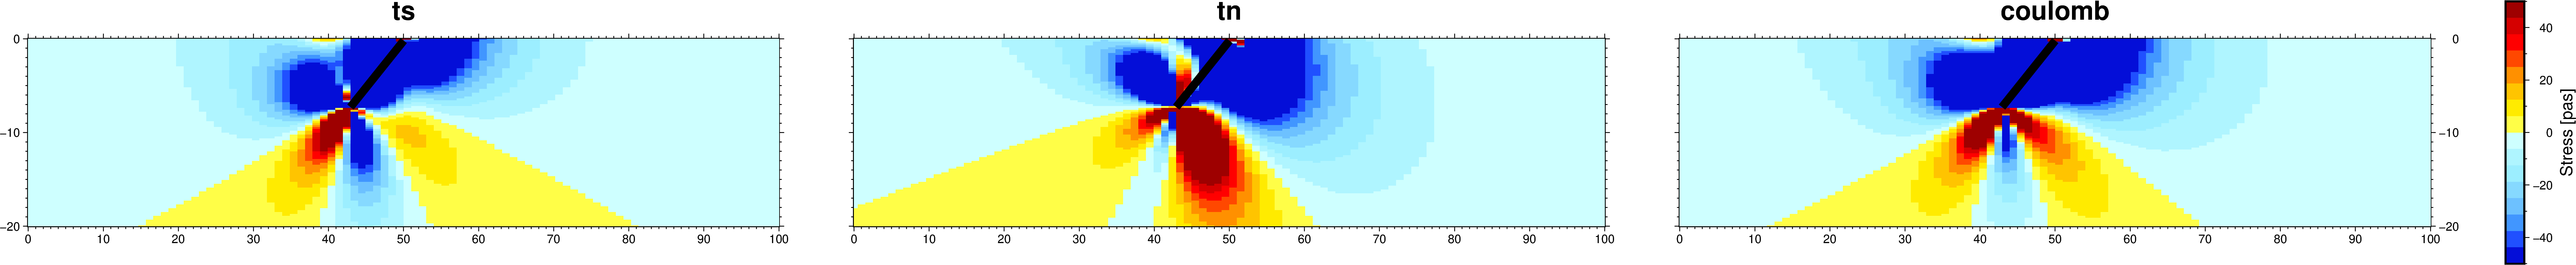

In [53]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 50#float(shear_da.max().data) * 0.05
mmin = -50#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ts_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=tn_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show(width=1200)

# Right laterl strike slip
## strike 0
## dip 90
## strike element = -1

In [2]:
strike, dip = 0, 90

In [3]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * 0.1

/var/folders/c_/7wmr5s157236k916wk7m39800000gn/T/ipykernel_29690/710888491.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))


In [4]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [5]:
x = 50.01
y = 50.01
z = 0.2
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = 10.0
W = 10.0
slip_strike = -1.0
slip_dip = 0.0
s_open = 0.0

In [6]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[50.01, 45.01,  0.2 ],
       [50.01, 55.01,  0.2 ],
       [50.01, 55.01, 10.2 ],
       [50.01, 45.01, 10.2 ]])

In [12]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false,
	"origin_lon":0,
	"origin_lat":0
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [13]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

# reciver dislocation
## calculating the stress on the same orentaion (dip:90 strike:0)
## rake:180 represent right lateral strike slip

In [14]:
r_strike = np.radians(strike)
r_dip = np.radians(dip)
r_rake = np.radians(180)

In [15]:
yang_mod = 8*1e6
poisson = 0.25
lame_lambda = (yang_mod * poisson) / ((1 + poisson) * ( 1 - 2 * poisson))
shear_mod = yang_mod / (2 * (1 + poisson))
lame_lambda, shear_mod

(3200000.0, 3200000.0)

In [17]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(np.array([1]))
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


In [18]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
inv_tn = get_array(tn, X[0, :], Y[:, 0])
inv_ts = get_array(ts, X[0, :], Y[:, 0])
inv_coulomb = get_array(coulomb, X[0, :], Y[:, 0])

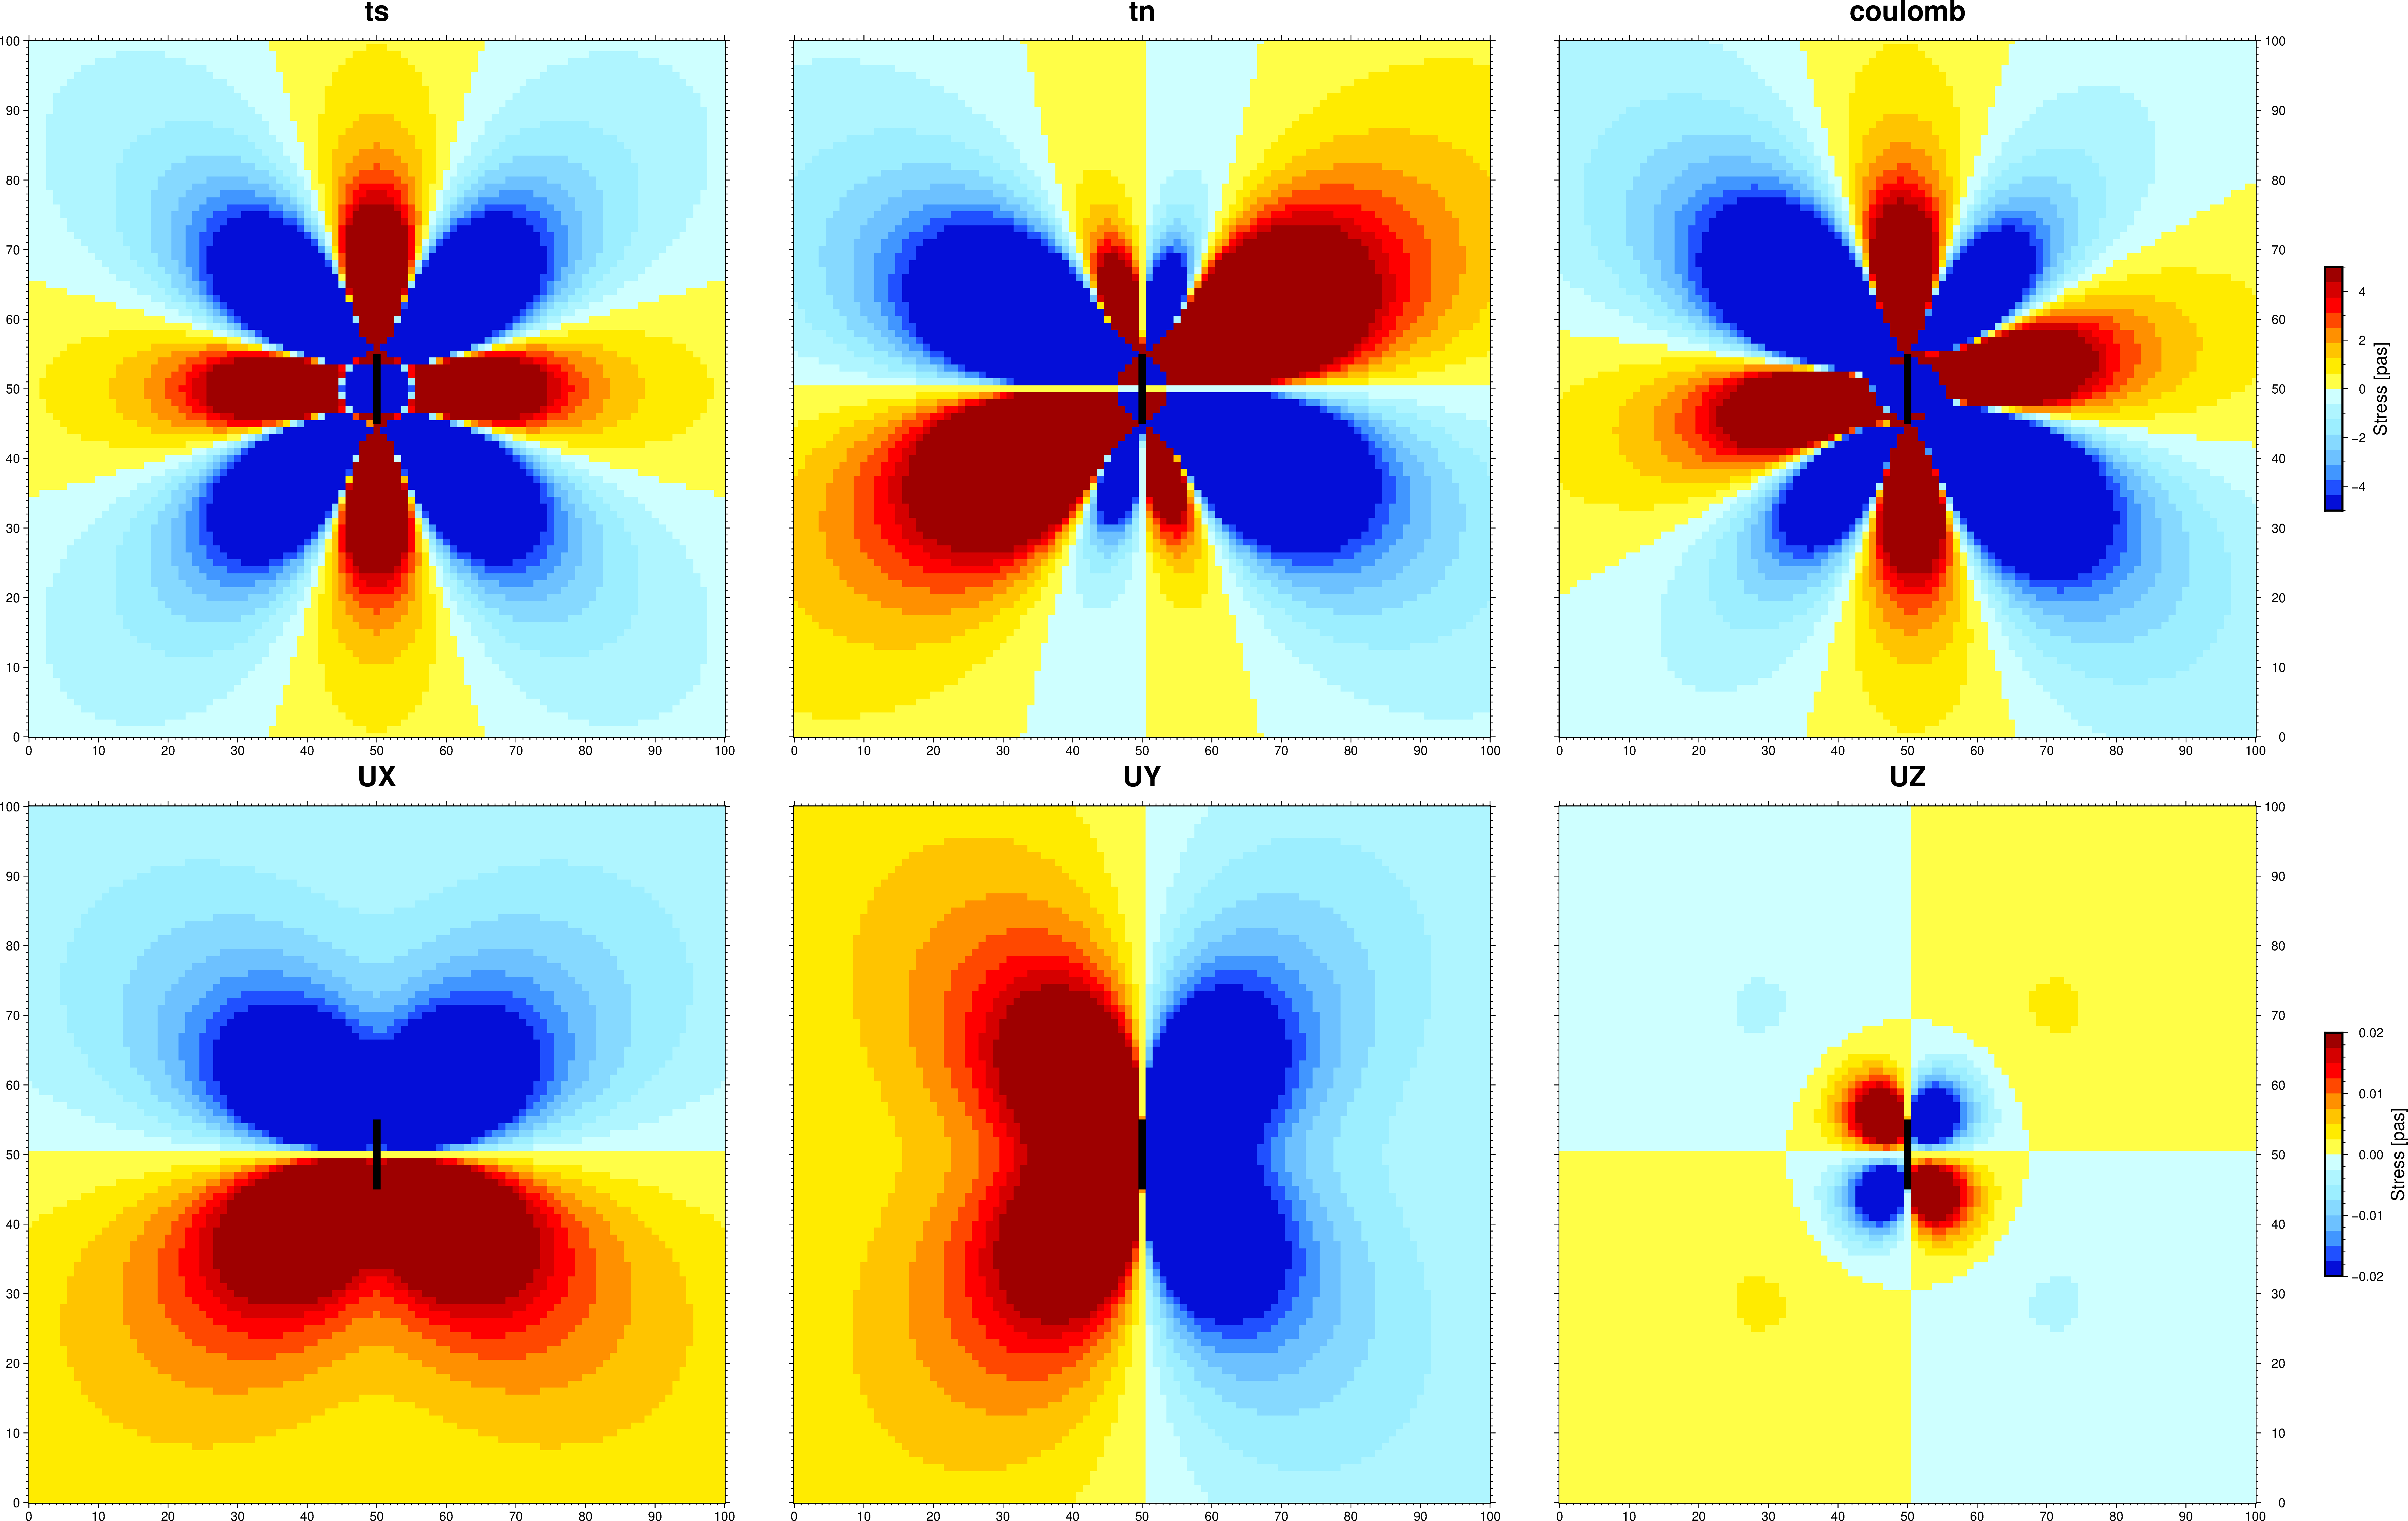

In [20]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44c', yshift='22c')



fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')
fig.savefig('strike_0_dip_0_rl.png')
fig.show()

In [84]:
X, Z = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, -20, 100))
Y = np.ones_like(X) * 50.0

In [85]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
tn_da = get_array(tn, X[0, :], Z[:, 0])
ts_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [86]:
region=[0,100,-20,0]

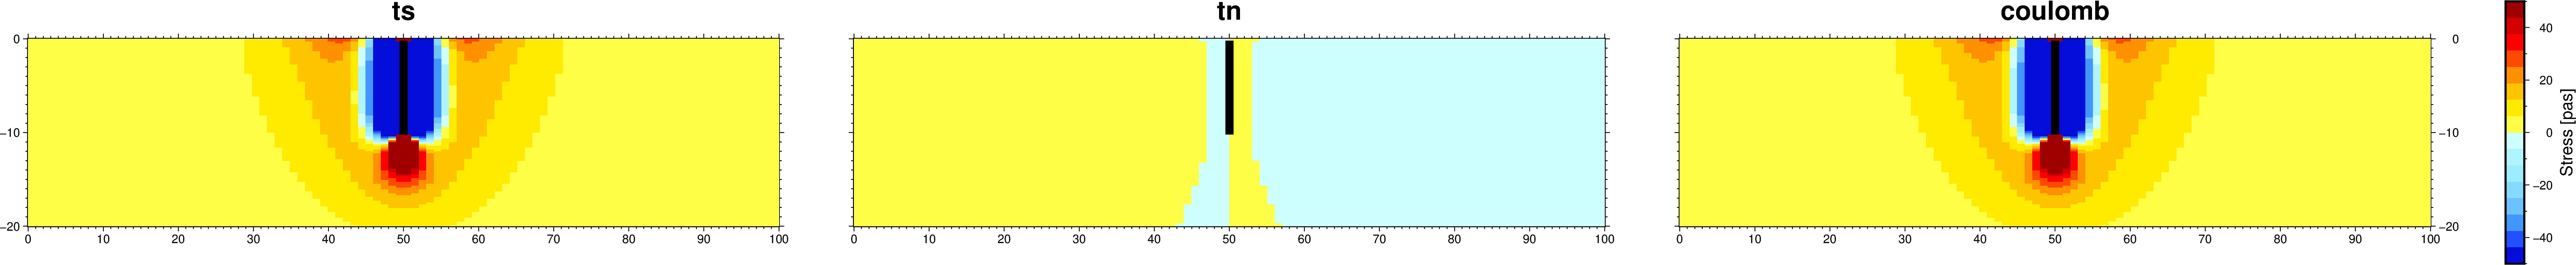

In [87]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 50#float(shear_da.max().data) * 0.05
mmin = -50#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ts_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=tn_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show(width=1200)

# Left laterl strike slip
## strike 180
## dip 90
## strike element = 1

In [88]:
strike, dip = 0, 90

In [101]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * 0.1

In [102]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [103]:
x = 50.01
y = 50.01
z = 0.2
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = 10.0
W = 10.0
slip_strike = 1.0
slip_dip = 0.0
s_open = 0.0

In [104]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[50.01, 45.01,  0.2 ],
       [50.01, 55.01,  0.2 ],
       [50.01, 55.01, 10.2 ],
       [50.01, 45.01, 10.2 ]])

In [105]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [106]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

# reciver dislocation
## calculating the stress on the same orentaion (dip:90 strike:0)
## rake:0 represent right lateral strike slip

In [107]:
r_strike = np.radians(strike)
r_dip = np.radians(dip)
r_rake = np.radians(0)

In [108]:
yang_mod = 8*1e6
poisson = 0.25
lame_lambda = (yang_mod * poisson) / ((1 + poisson) * ( 1 - 2 * poisson))
shear_mod = yang_mod / (2 * (1 + poisson))
lame_lambda, shear_mod

(3200000.0, 3200000.0)

In [109]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(inv.solution)
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


In [110]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
inv_tn = get_array(tn, X[0, :], Y[:, 0])
inv_ts = get_array(ts, X[0, :], Y[:, 0])
inv_coulomb = get_array(coulomb, X[0, :], Y[:, 0])

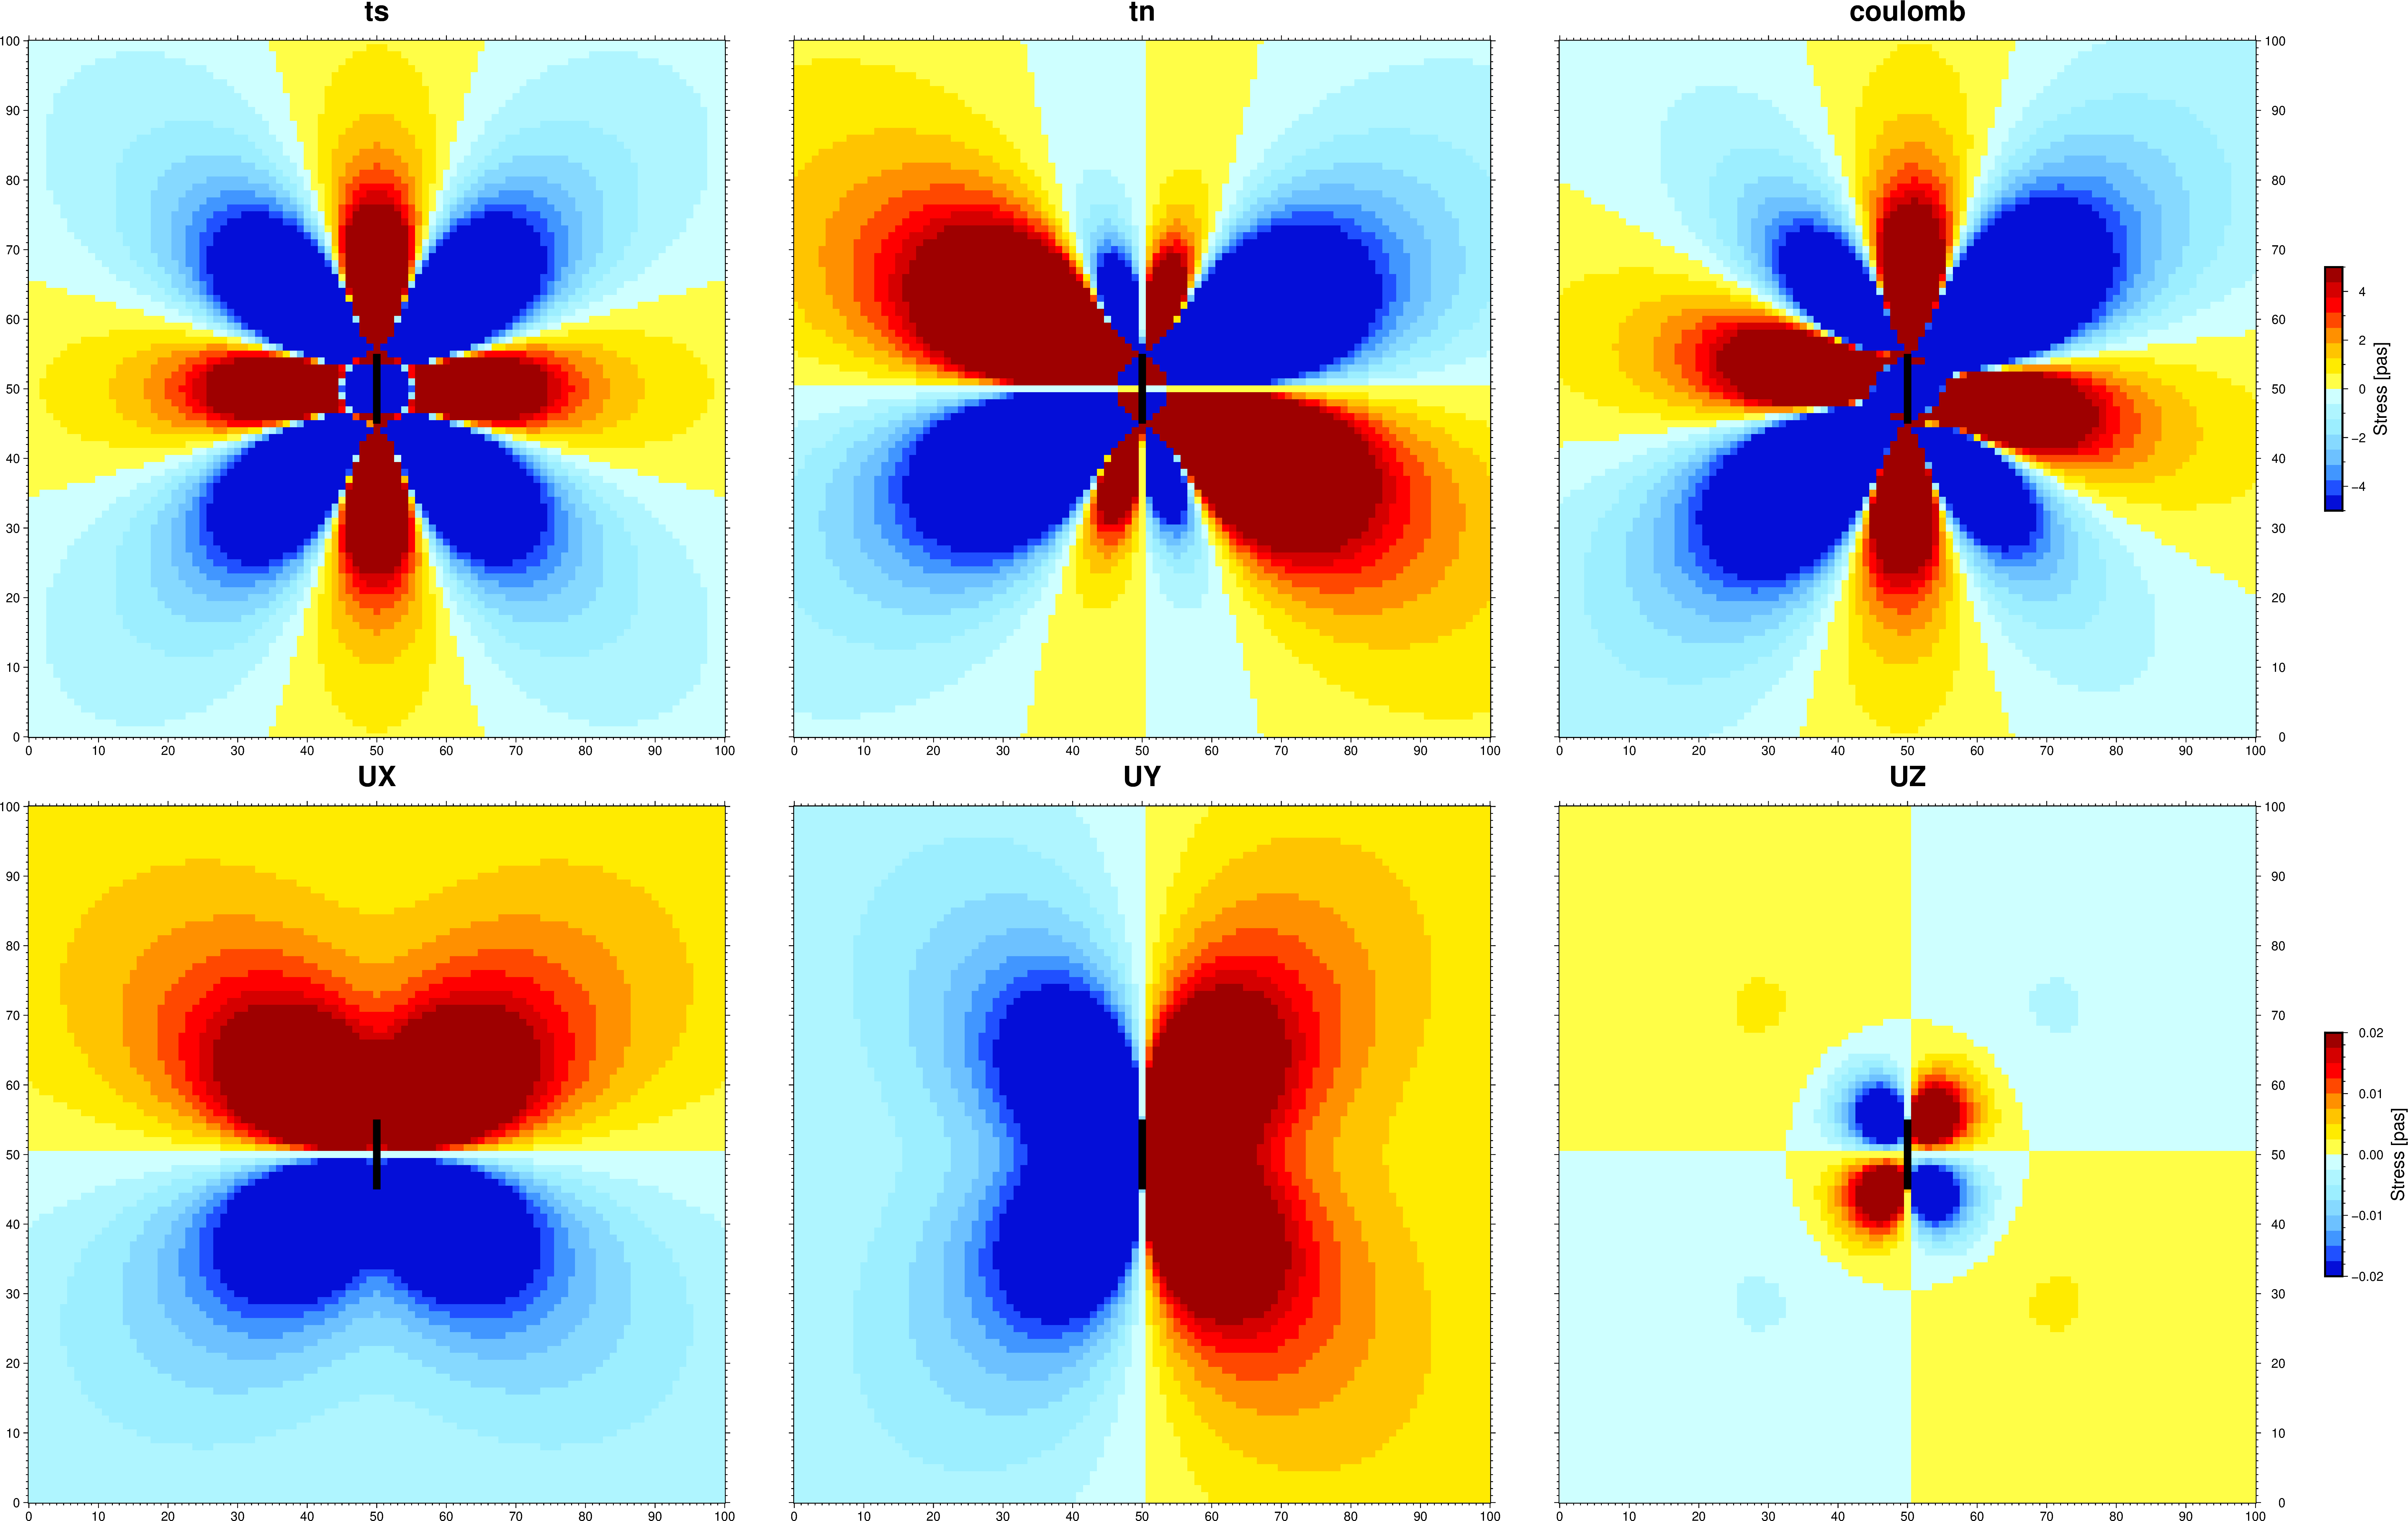

In [111]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44c', yshift='22c')



fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [112]:
X, Z = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, -20, 100))
Y = np.ones_like(X) * 50.0

In [113]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
tn_da = get_array(tn, X[0, :], Z[:, 0])
ts_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [114]:
region=[0,100,-20,0]

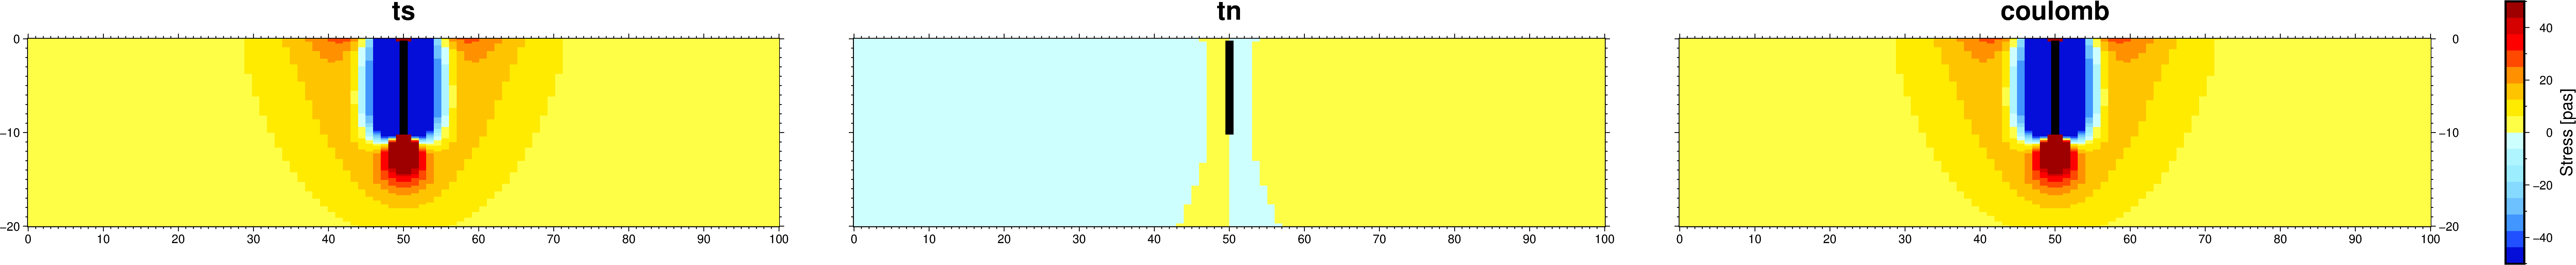

In [115]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 50#float(shear_da.max().data) * 0.05
mmin = -50#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ts_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=tn_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show(width=1200)

# Some random fault on a random reciver fault

In [117]:
strike, dip = np.random.uniform(0, 360, 1)[0], np.random.uniform(0, 90, 1)[0]

In [118]:
X, Y = np.meshgrid(np.arange(0, 101, dtype=np.float), np.arange(0, 101, dtype=np.float))
Z = np.ones_like(X) * 0.1

In [69]:
tdf= pd.DataFrame(dict(x=X.flatten() * 1e3, y=Y.flatten() * 1e3, id=0,E=0,Se=0,N=0,Sn=0,U=0,Su=0, lon=X.flatten(), lat=Y.flatten()))
tdf.to_csv('ttt.csv')

In [119]:
x = np.random.uniform(20, 80, 1)[0]
y = np.random.uniform(20, 80, 1)[0]
z = np.random.uniform(0, 10, 1)[0]
d_strike = np.radians(strike)
d_dip = np.radians(dip)
L = np.random.uniform(5, 20, 1)[0]
W = np.random.uniform(5, 20, 1)[0]
slip_strike = np.random.uniform(-1, 1, 1)[0]
slip_dip = np.random.uniform(-1, 1, 1)[0]
s_open = 0.0

In [120]:
ccw_to_x_stk = np.pi / 2 - d_strike
ccw_to_x_dip = - d_strike + np.pi
deast = np.cos(ccw_to_x_stk) * L * 0.5
dnorth = np.sin(ccw_to_x_stk) * L * 0.5
"""
p1 ------------ p2
   |           |
   |           |
   |           |
p4 ------------ p3

"""
p1 = np.array([x - deast, y - dnorth, z])
p2 = np.array([x + deast, y + dnorth, z])

l = W * np.cos(d_dip)
x_b = x -  np.cos(ccw_to_x_dip) * l
y_b = y - np.sin(ccw_to_x_dip) * l
p3 = np.array([x_b + deast, y_b + dnorth, z + W * np.sin(d_dip)])
p4 = np.array([x_b - deast, y_b - dnorth, z + W * np.sin(d_dip)])
plain_cords = np.stack((p1, p2, p3, p4))
plain_cords

array([[75.4244743 , 28.62942933,  7.55122547],
       [69.10097828, 25.74971837,  7.55122547],
       [68.36997934, 27.3549034 , 12.59520252],
       [74.69347535, 30.23461437, 12.59520252]])

In [121]:
inv_pars = '''{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":%f,
		"strike":%f,
		"plain_cord":[%f, %f, %f],
		"plain_length":%f,
		"width":[%f],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":%f,
		"dip_element":%f,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}

''' %(np.degrees(d_dip), np.degrees(d_strike), plain_cords[0, 0], plain_cords[0, 1], plain_cords[0, 2], L, W, slip_strike, slip_dip)

In [122]:
print(inv_pars)

{
"global_parameters":
	{
	"poisson_ratio":0.25,
	"shear_modulus":30e9,
	"smooth":0.1,
	"dip_element":1,
	"strike_element":1,
    "open_element":0,
	"compute_mean":false,
	"boundary_constrained":false
	},
"plains":
	{
	"plain1":
		{
		"dip":70.726100,
		"strike":245.515549,
		"plain_cord":[75.424474, 28.629429, 7.551225],
		"plain_length":6.948333,
		"width":[5.343471],
		"num_sub_stk":[1],
		"smooth_up":[],
		"strike_element":-0.508787,
		"dip_element":-0.064056,
		 "total_width":10
		}
	},
"gps":
	{
	"gps_set_1":
		{
		"data":"./ttt.csv"
		}
	}
}




In [123]:
with open('__temp.json', 'w') as f:
    f.write(inv_pars)
inv = Inversion('__temp.json')

# reciver dislocation

In [124]:
r_strike = np.radians(np.random.uniform(0, 360, 1)[0])
r_dip = np.radians(np.random.uniform(0, 90, 1)[0])
r_rake = np.radians(np.random.uniform(0, 360, 1)[0])

In [125]:
yang_mod = 8*1e6
poisson = 0.25
lame_lambda = (yang_mod * poisson) / ((1 + poisson) * ( 1 - 2 * poisson))
shear_mod = yang_mod / (2 * (1 + poisson))
lame_lambda, shear_mod

(3200000.0, 3200000.0)

In [126]:
inv.solution = np.array([np.abs(slip_strike), np.abs(slip_dip)])
strike_slip = np.array([0.0])
inv.build_kers()
inv.build_sources_mat()
plain_cords = inv.plains[0].sources[0].get_cords().T
inv_disp = inv.gps[0].save_model(inv.solution)
inv_ux = get_array(inv_disp.E.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uy = get_array(inv_disp.N.values.reshape(X.shape), X[0, :], Y[:, 0])
inv_uz = get_array(inv_disp.Up.values.reshape(X.shape), X[0, :], Y[:, 0])


In [127]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
inv_tn = get_array(tn, X[0, :], Y[:, 0])
inv_ts = get_array(ts, X[0, :], Y[:, 0])
inv_coulomb = get_array(coulomb, X[0, :], Y[:, 0])

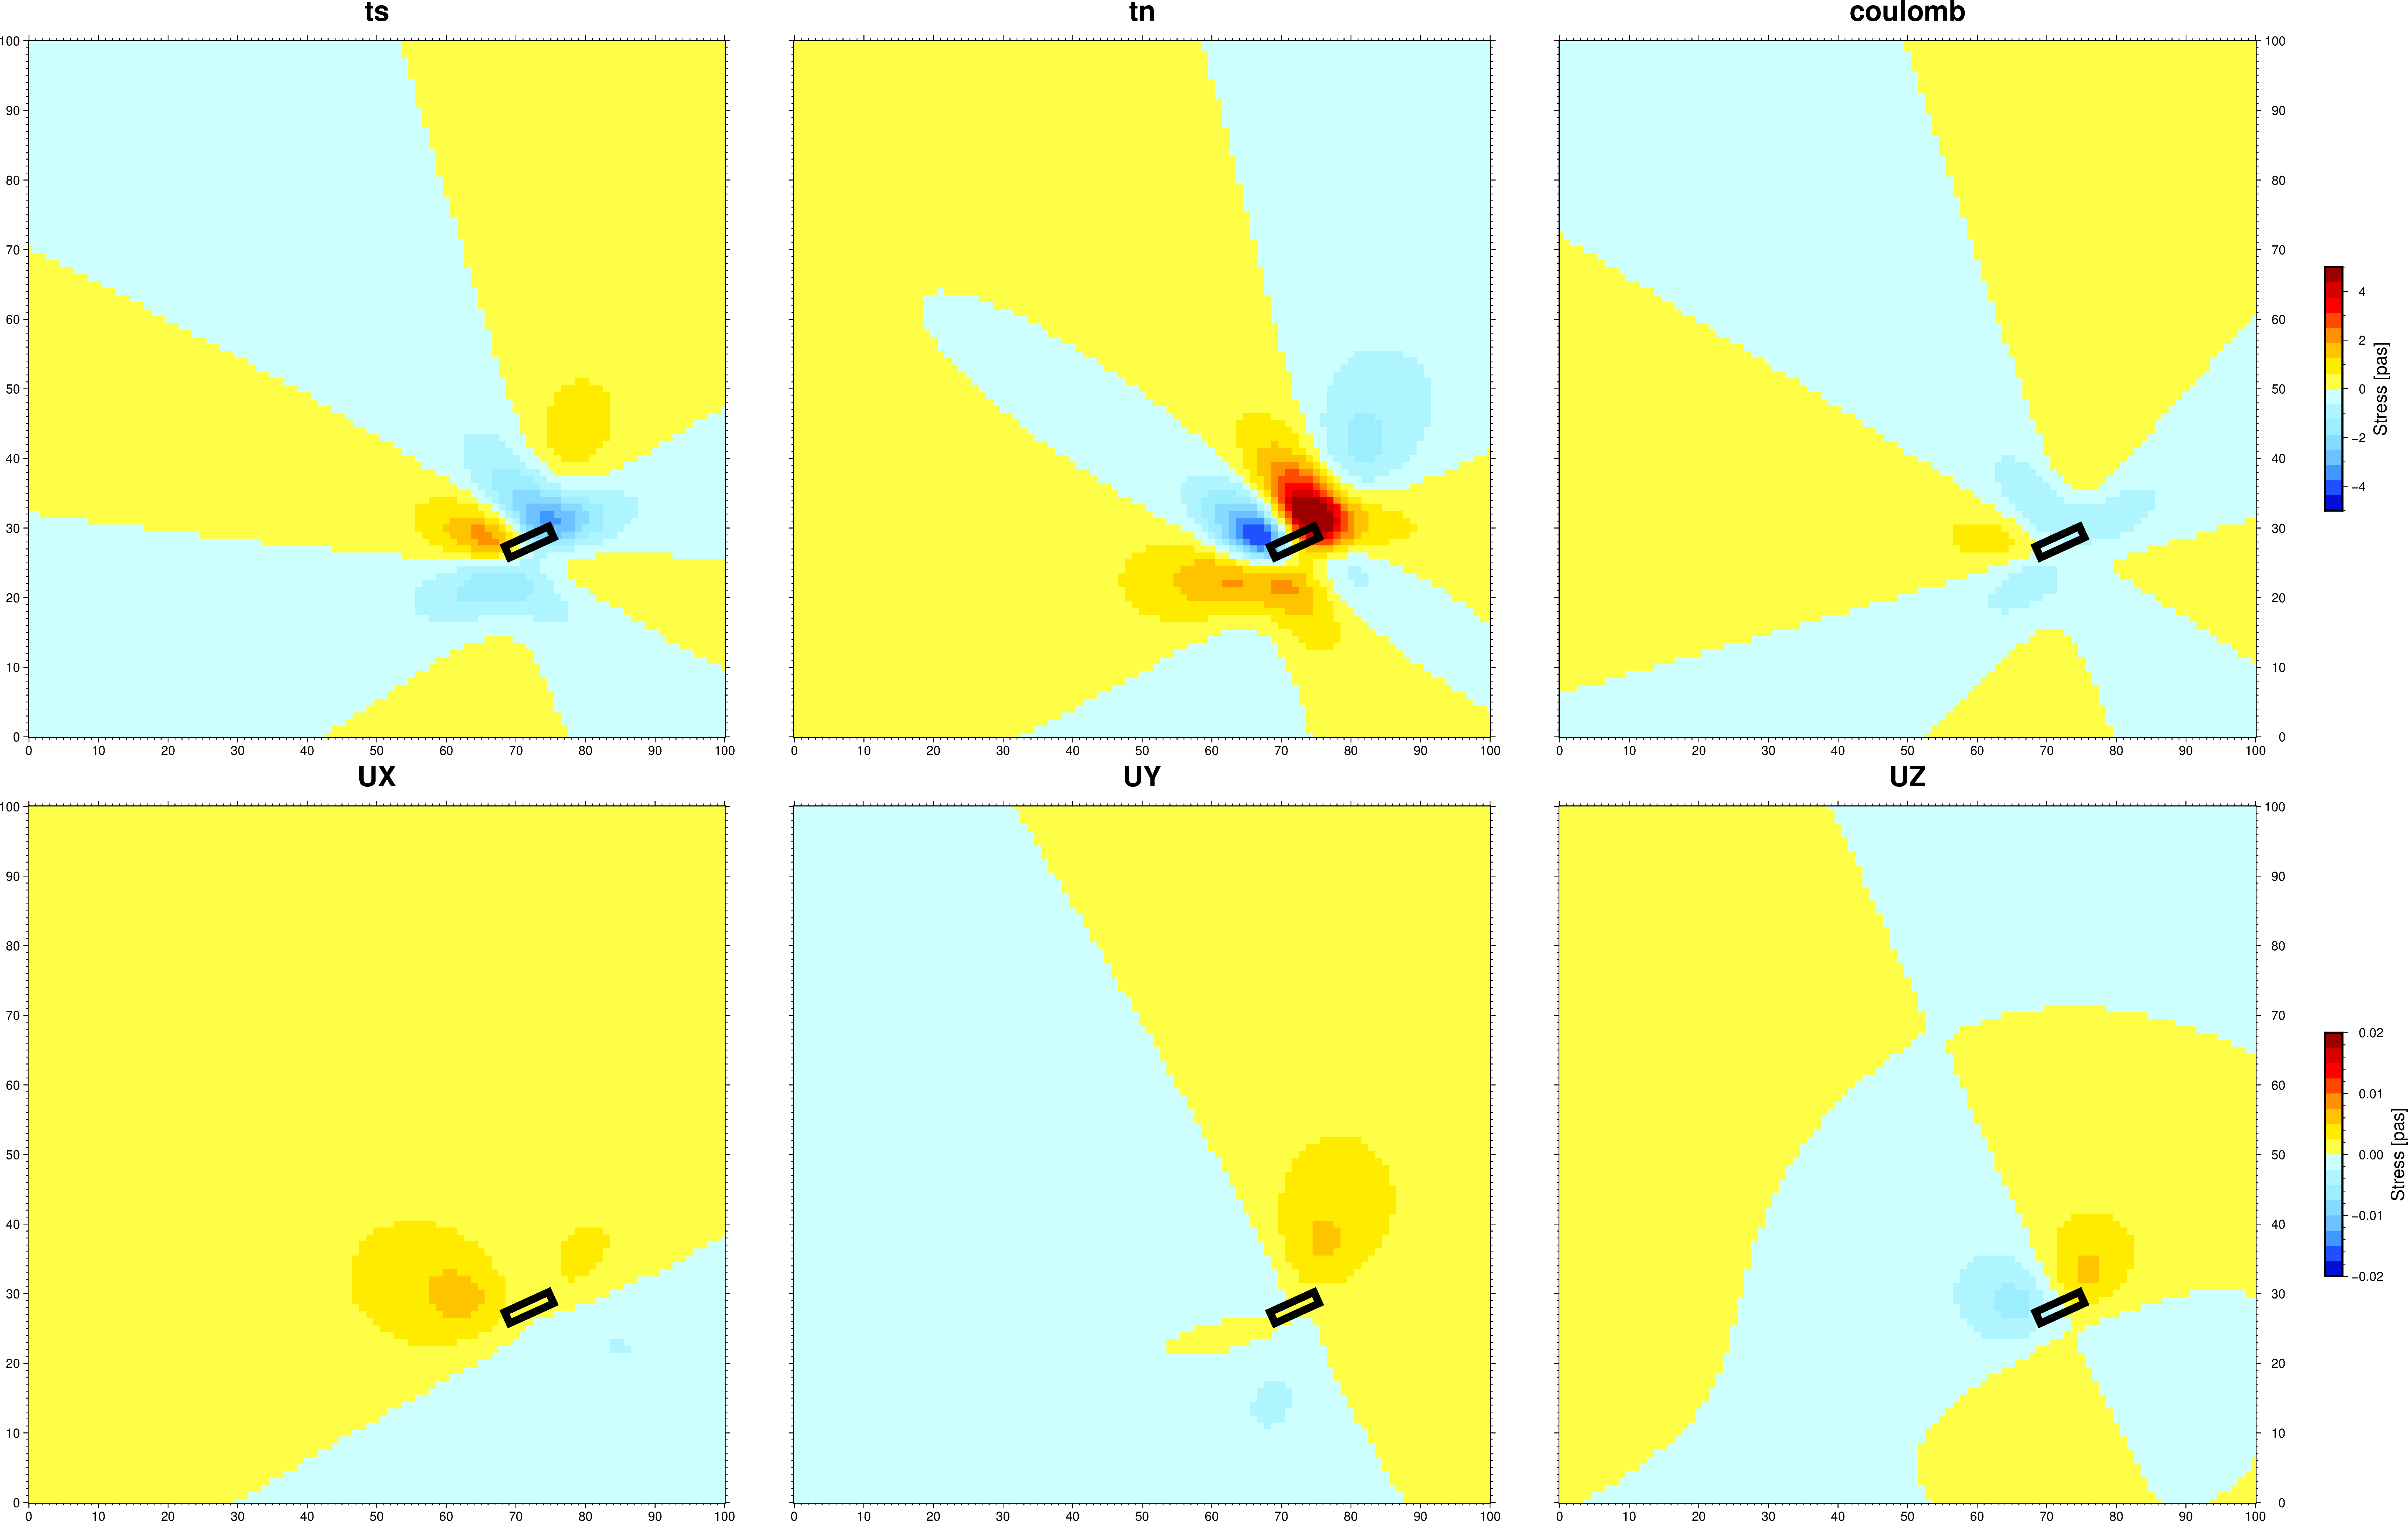

In [128]:
region=[0, 100, 0, 100]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"UX"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 0.02#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -0.02#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ux)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"UY"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uy)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"UZ"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_uz)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.shift_origin(xshift='-44c', yshift='22c')



fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)
mmax = 5#max(float(ux.max().data), float(uy.max().data), float(uz.max().data)) * 0.1
mmin = -5#min(float(ux.min().data), float(uy.min().data), float(uz.min().data)) * 0.1
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=inv_ts)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_tn)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20",
    region=region
)

fig.grdimage(grid=inv_coulomb)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 1],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show()

In [129]:
X, Z = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, -20, 100))
Y = np.ones_like(X) * 50.0

In [130]:
coulomb, tn, ts = inv.calc_coulomb_2d(0.4, X, Y, Z, np.degrees(r_strike), np.degrees(r_dip),
                                      np.degrees(r_rake), lambda_l=lame_lambda, shear_m=shear_mod)
tn_da = get_array(tn, X[0, :], Z[:, 0])
ts_da = get_array(ts, X[0, :], Z[:, 0])
coulomb_da = get_array(coulomb, X[0, :], Z[:, 0])

In [131]:
region=[0,100,-20,0]

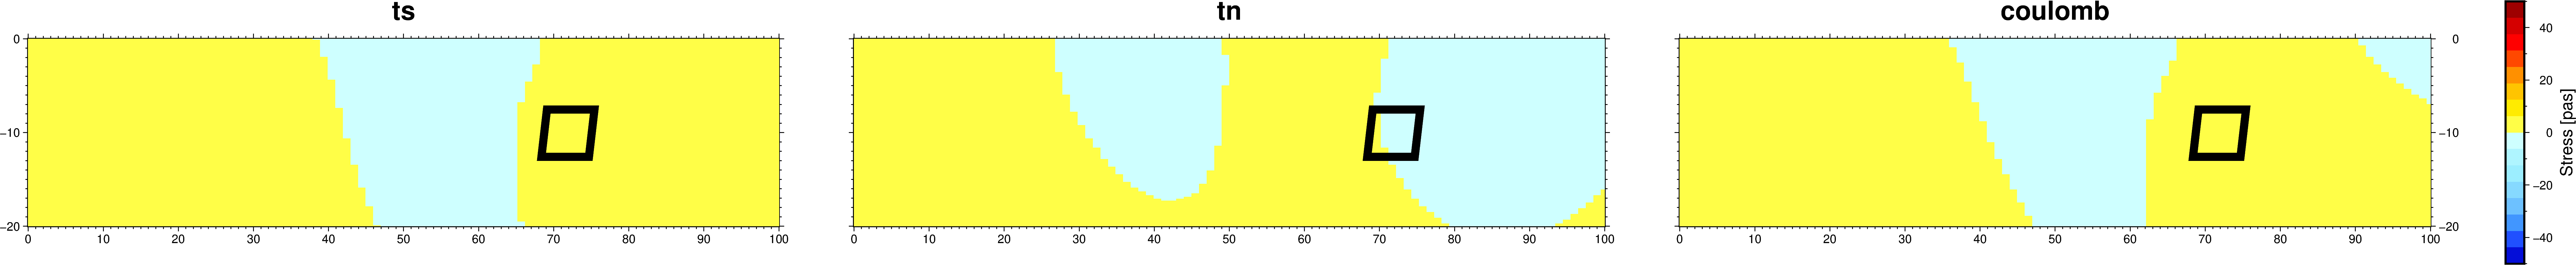

In [132]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

fig.basemap(
    frame=['WSne+t"ts"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)
mmax = 50#float(shear_da.max().data) * 0.05
mmin = -50#float(shear_da.min().data) * 0.05
pygmt.makecpt(cmap="panoply", series=[mmin,mmax], background=True)

fig.grdimage(grid=ts_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSne+t"tn"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=tn_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)

fig.shift_origin(xshift='22')
fig.basemap(
    frame=['wSnE+t"coulomb"', 'xa10f1g10', 'ya10f1g10'],
    projection=f"X20/5",
    region=region
)

fig.grdimage(grid=coulomb_da)
fig.plot(
    x= plain_cords[:, 0],
    y = plain_cords[:, 2],
    pen='6,black',
    close=True
)
fig.colorbar(position="JMR+o2c/0c+w7c/0.5c", frame='af+l"Stress [pas]"')

fig.show(width=1200)